In [11]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge1.gwf
! pip install -U -q bilby==2.4.0 matplotlib==3.10.0 dynesty==2.1.5 corner==2.2.3 gwpy==3.0.12 lalsuite==7.25 scipy==1.12.0
# -- for gwpy

--2025-07-26 13:17:06--  https://dcc.ligo.org/public/0187/G2300818/001/challenge1.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025680 (3.8M)
Saving to: ‘challenge1.gwf.1’

challenge1.gwf.1    100%[===================>]   3.84M  9.83MB/s    in 0.4s    

2025-07-26 13:17:06 (9.83 MB/s) - ‘challenge1.gwf.1’ saved [4025680/4025680]



In [1]:
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge1.gwf', channel="H1:CHALLENGE1")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

/usr/local/lib/python3.11/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
import matplotlib.pyplot as plt
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass


# Challenge 1


In [15]:
import bilby
sampling_rate = 2048  # needs to be high enough for the signals found in steps above
duration = 8  # needs to be long enough for the signals found in steps above
start_time = 100  # needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1']: # Changed to only iterate over H1
    ifo = bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge1.gwf', sampling_rate, duration, start_time=start_time, channel=f'{ifo_name}:CHALLENGE1')
    interferometers.append(ifo)

13:22 bilby INFO    : Reading data from frame file challenge1.gwf
13:22 bilby INFO    : Successfully loaded H1:CHALLENGE1.


In [16]:

print(f"Data time duration: {gwpy_strain.duration} seconds")
print(f"Sampling rate: {gwpy_strain.sample_rate} Hz")

Data time duration: 4096.0 s seconds
Sampling rate: 4096.0 Hz Hz


Text(0.5, 0, 'Time')

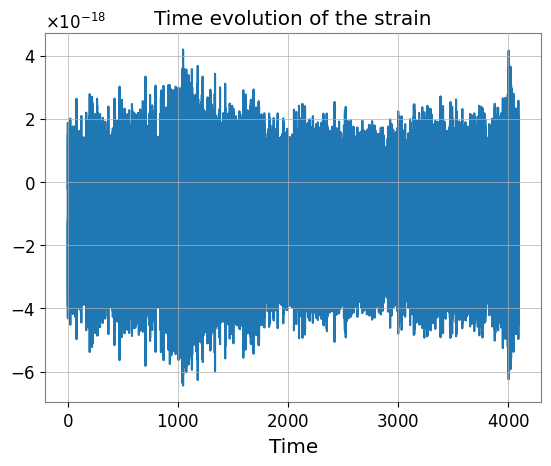

In [17]:
plt.plot(gwpy_strain.times, gwpy_strain)
plt.title("Time evolution of the strain")
plt.xlabel("Time")

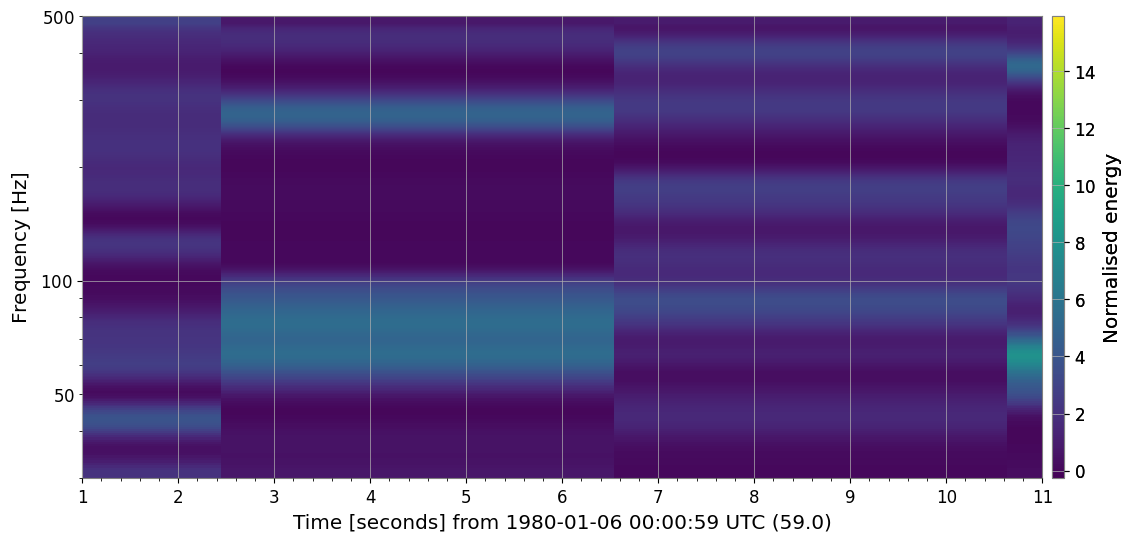

In [18]:
q_gw = gwpy_strain.q_transform(frange=(30, 500))
plot = q_gw.plot()
plot.colorbar(label="Normalised energy")
ax = plot.gca()
ax.set_xlim(60,70)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

From the spectrogram we can see that time of the merger occurs at 66 seconds in the data frame.

# Challenge 2


In [19]:
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge2.gwf

gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")


pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

--2025-07-26 13:24:04--  https://dcc.ligo.org/public/0187/G2300818/001/challenge2.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025853 (3.8M)
Saving to: ‘challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  9.90MB/s    in 0.4s    

2025-07-26 13:24:04 (9.90 MB/s) - ‘challenge2.gwf’ saved [4025853/4025853]



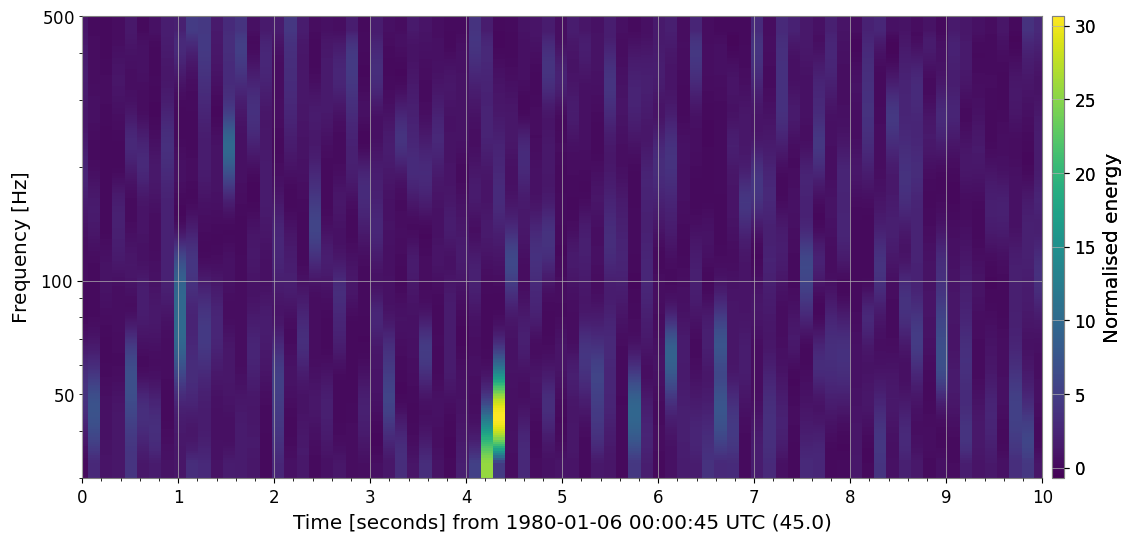

In [20]:
q_gw_2 = gwpy_strain.q_transform(frange=(30, 500))
plot = q_gw_2.plot()
plot.colorbar(label="Normalised energy")
ax = plot.gca()
ax.set_xlim(45,55)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

The time of the merger seems to be about 49 seconds in the data frame


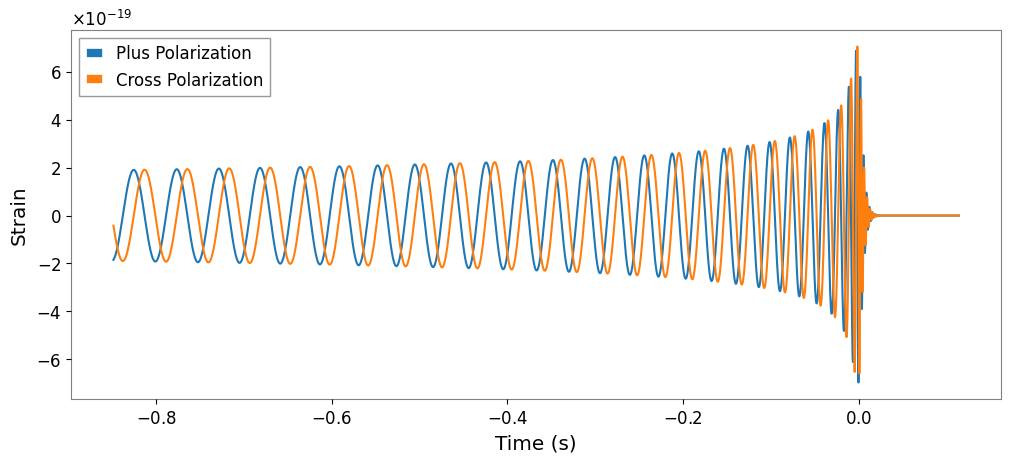

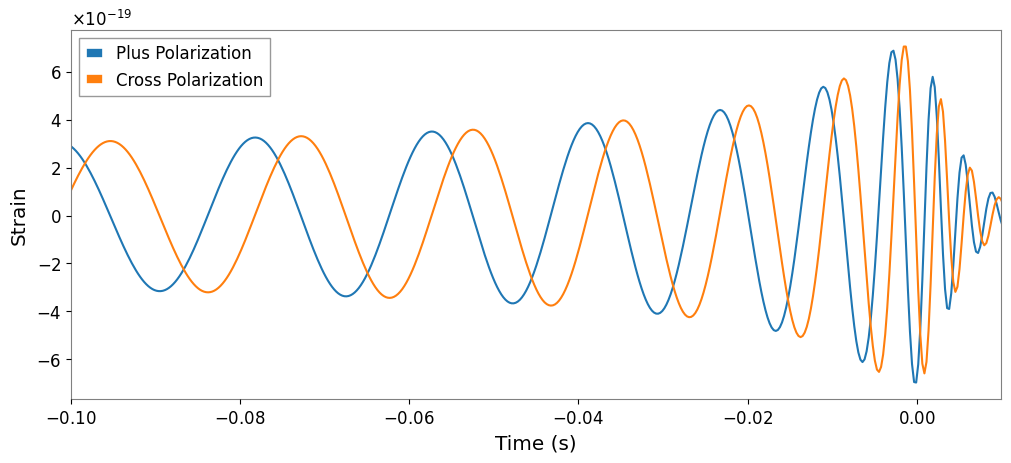

In [21]:
from pycbc.waveform import get_td_waveform, fd_approximants
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/4096,
                         f_lower=20)
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid()
plt.show()
# Zoom in near the merger time
plt.figure(figsize=plt.figaspect(0.4))
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(-.1, .01)
plt.legend()
plt.grid()
plt.show()


In [22]:
strain = highpass(pycbc_strain, 15.0) # Use pycbc_strain for highpass
#strain = resample_to_delta_t(strain, 1.0/2048)
#conditioned = strain.crop(2, 2)
conditioned = pycbc_strain

In [23]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency.
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

(20, 2048)

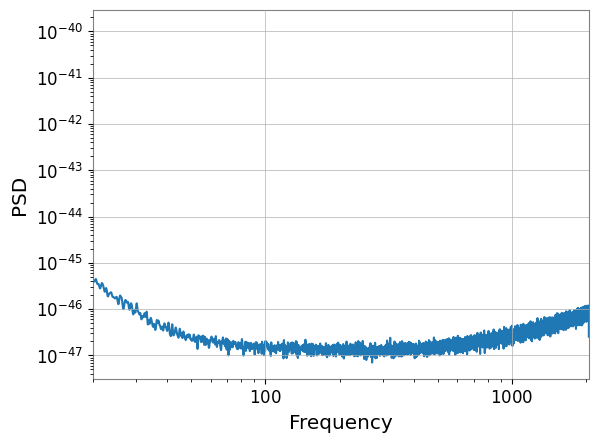

In [24]:
plt.loglog(psd.sample_frequencies, psd)
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.xlim(20, 2048)

In [25]:
strain = highpass(pycbc_strain, 15.0) # Use pycbc_strain for highpass
strain = resample_to_delta_t(strain, 1.0/4096)
conditioned = strain.crop(2, 2)
hp.resize(len(conditioned))

In [26]:
print(conditioned.delta_f)
print(f"Data time duration: {gwpy_strain.duration} seconds")
print(f"Sampling rate: {pycbc_strain.sample_rate} Hz")

0.008064516129032258
Data time duration: 128.0 s seconds
Sampling rate: 4096.0 Hz


## Match filtering

In [27]:
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

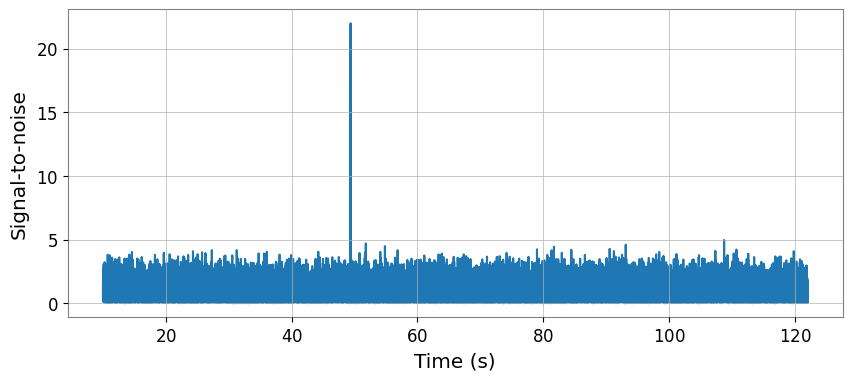

We found a signal at 49.3671875s with SNR 21.98392657432563


In [28]:
from pycbc.filter import matched_filter
import numpy
template = hp.cyclic_time_shift(hp.start_time)

# Resample the template to match the conditioned data
template = resample_to_delta_t(template, conditioned.delta_t)
if len(template) > len(conditioned):
    template = template[:len(conditioned)]
elif len(template) < len(conditioned):
    conditioned = conditioned[:len(template)]


snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=15)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for
# so short a template). A longer signal such as from a BNS, would
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion corresponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be
# anything, we choose to maximize over the phase of the signal.
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

# Challenge 3


In [29]:
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf

gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")


pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')

--2025-07-26 13:24:30--  https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.133
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256814830 (245M)
Saving to: ‘challenge3.gwf.1’

challenge3.gwf.1    100%[===================>] 244.92M  37.9MB/s    in 6.9s    

2025-07-26 13:24:37 (35.2 MB/s) - ‘challenge3.gwf.1’ saved [256814830/256814830]



In [30]:
strain = highpass(pycbc_strain, 15.0) # Use pycbc_strain for highpass
strain = resample_to_delta_t(strain, 1.0/4096) # This resamples the strain data
conditioned = strain.crop(2, 2)
# hp.resize(len(conditioned)) # This should be done after the template is created and resampled

# Add a check to ensure conditioned data is not None
if conditioned is None or len(conditioned) == 0:
    raise ValueError("Conditioned data is empty or None after cropping.")

In [31]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096, # Use the desired delta_t for the template
                         f_lower=20)
hp = resample_to_delta_t(hp, conditioned.delta_t) # Resample template to match conditioned data
# Ensure template is not longer than conditioned data
if len(hp) > len(conditioned):
    hp = hp[:len(conditioned)]

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time) # Apply cyclic time shift

Before applying the match filtering procedure, we rescale the SNR in order to remove non gaussianities:

$\hat{\rho} = \frac{\rho}{ \frac{1}{2}[1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$

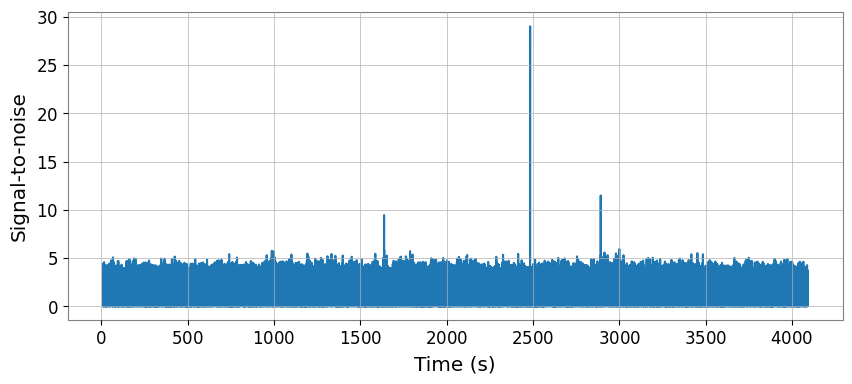

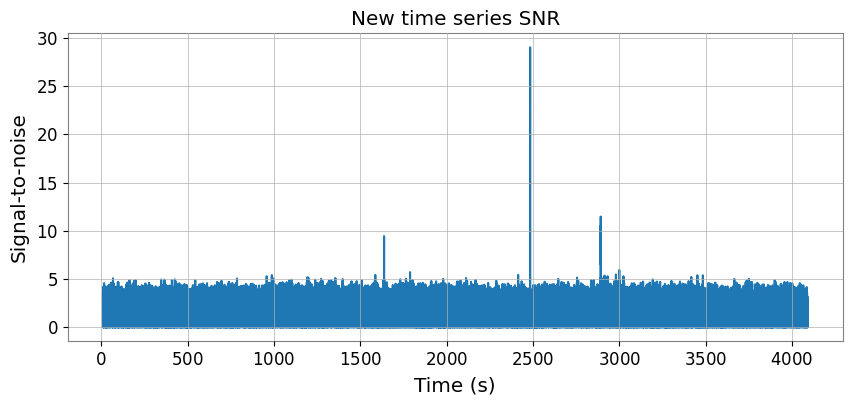

We found a signal at 2483.967529296875s with SNR 29.012553476541804


In [32]:
from pycbc.events.ranking import newsnr
from pycbc.vetoes import power_chisq
import numpy as np
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=15)


snr = snr.crop(4 + 4, 4)
nbins = 26
chisq_x = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)

# Crop chisq_x to match the cropped snr
chisq_x = chisq_x.crop(4+4, 4)

dof_x = nbins * 2 - 2
chisq_x /= dof_x


# The rho-hat term above is named "newsnr" here
nsnr_x = newsnr(abs(snr), chisq_x)
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = nsnr_x.argmax() # Use nsnr_x instead of newsnr
snrp = nsnr_x[peak] # Use nsnr_x instead of newsnr
time = snr.sample_times[peak]

plt.figure(figsize = [10,4]) # Fix the typo here
plt.plot(snr.sample_times, abs(nsnr_x)) # Use nsnr_x instead of newsnr
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.title("New time series SNR")
plt.show()
print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [33]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(nsnr_x, height=5)  # puoi regolare il threshold
top3_idx = peaks[np.argsort(nsnr_x[peaks])[-3:]]

for i, idx in enumerate(top3_idx):
    print(f"\n Peak {i+1}")
    print(f"Time: {snr.sample_times[idx]:.2f} s")
    print(f"SNR: {abs(snr[idx]):.2f}")
    print(f"newsnr: {nsnr_x[idx]:.2f}")
    print(f"Reduced chi²: {chisq_x[idx]:.2f}")


    t0 = snr.sample_times[idx]
    mask = (snr.sample_times >= t0 - 2) & (snr.sample_times <= t0 + 2)




 Peak 1
Time: 2892.75 s
SNR: 10.52
newsnr: 10.52
Reduced chi²: 0.99

 Peak 2
Time: 2892.71 s
SNR: 11.48
newsnr: 11.48
Reduced chi²: 0.92

 Peak 3
Time: 2483.97 s
SNR: 29.01
newsnr: 29.01
Reduced chi²: 1.00


It seems that there are three distinct signal in our data, even after rescaling the snr.

# Challenge 4

In [34]:
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="L1:CHALLENGE3")

pycbc_strain = frame.read_frame('challenge3.gwf', 'L1:CHALLENGE3')

In [35]:
strain = highpass(pycbc_strain, 15.0) # Use pycbc_strain for highpass
strain = resample_to_delta_t(strain, 1.0/4096)
conditioned = strain.crop(2, 2)


In [36]:
mass = np.arange(10,51)

glitch_list = []
snr_list = []
snr_sig_peaks = []
chisq_list = []
time_list = []
time_glitches =[]
whitened_strain = conditioned.whiten(4, 4)
psd = whitened_strain.psd(4)
psd = interpolate(psd, whitened_strain.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * whitened_strain.sample_rate),
                                  low_frequency_cutoff=15)
for m in mass:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                          mass1=m,
                          mass2=m,
                          delta_t=1.0/4096, # Use the desired delta_t for the template
                          f_lower=20)
  hp = resample_to_delta_t(hp, whitened_strain.delta_t) # Resample template to match conditioned data




  hp.resize(len(whitened_strain))
  template = hp.cyclic_time_shift(hp.start_time) # Apply cyclic time shift



  snr_i = matched_filter(template, whitened_strain, psd=psd, low_frequency_cutoff=15) # Fix: Use conditioned data


  snr_i = snr_i.crop(8, 4)



  nbins = 26
  peaks, _ = find_peaks(abs(snr_i), height=5)
  chisq_x = power_chisq(hp, whitened_strain, nbins, psd, low_frequency_cutoff=20.0)

  # Crop chisq_x to match the cropped snr
  chisq_x = chisq_x.crop(8, 4)

  dof_x = nbins * 2 - 2
  chisq_x /= dof_x


  # The rho-hat term above is named "newsnr" here
  nsnr_x = newsnr(abs(snr_i), chisq_x)

  frac_diff = np.abs(snr_i[peaks] - nsnr_x[peaks]) / abs(snr_i[peaks])
  high_chisq = chisq_x[peaks] > 2
  idx_glitch = np.where((frac_diff > 0.2) & high_chisq)

  glitches = snr_i[peaks][idx_glitch] # Index peaks into snr_i before idx_glitch
  signal_peaks = nsnr_x[peaks]
  time = snr_i.sample_times[nsnr_x.argmax()]

  snr_list.append(snr_i[peaks]) #list containing signal and glitches peaks
  snr_sig_peaks.append(signal_peaks) #list containing signal peaks
  chisq_list.append(chisq_x[peaks]) #list containing chi^2 of signal and glitches
  time_list.append(time)  #time of signal peak
  glitch_list.append(glitches)
  time_glitches.append(snr_i.sample_times[idx_glitch]) #time of glitches


In [37]:
all_glitch_times = np.concatenate(time_glitches)
unique_glitches = np.unique(np.round(all_glitch_times, 2)) #in order to avoid duplicates

In [38]:
#print(time_glitches)
print(len(time_glitches))
print(len(unique_glitches))
print(unique_glitches)

41
8
[12.   12.01 12.02 12.03 12.04 12.05 12.06 12.07]


In [39]:
#glitches spectrogram
from gwpy.timeseries import TimeSeries
from pycbc.types import TimeSeries as PycbcTimeSeries # Import Pycbc TimeSeries

for i, t_glitch in enumerate(unique_glitches):
        # Extract a segment of the conditioned data around the glitch time using pycbc
        # Increase the segment length to provide more data for q_transform
        segment_pycbc = conditioned.time_slice(t_glitch - 2, t_glitch + 2) # Extract a 4 second segment centered at the glitch

        if len(segment_pycbc) > 0:
            print(f"Generating spectrogram for glitch at t = {t_glitch:.2f}s...")
            try:
                # Convert pycbc TimeSeries segment to gwpy TimeSeries
                segment_gwpy = TimeSeries(segment_pycbc.data, sample_rate=segment_pycbc.sample_rate, t0=segment_pycbc.start_time)

                # Use gwpy's q_transform on the segment
                q_glitch = segment_gwpy.q_transform(frange=(30, 500), qrange=(4, 64))

                plot = q_glitch.plot()
                plot.colorbar(label="Normalised energy")
                ax = plot.gca()
                ax.set_yscale('log')
                ax.set_title(f"Spectrogram of Glitch at {t_glitch:.2f}s")
                plt.show()
            except Exception as e:
                print(f"Could not generate spectrogram for glitch at {t_glitch:.2f}s: {e}")
        else:
            print(f"Skipping glitch at {t_glitch:.2f}s: Could not extract segment.")


Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'Strain')

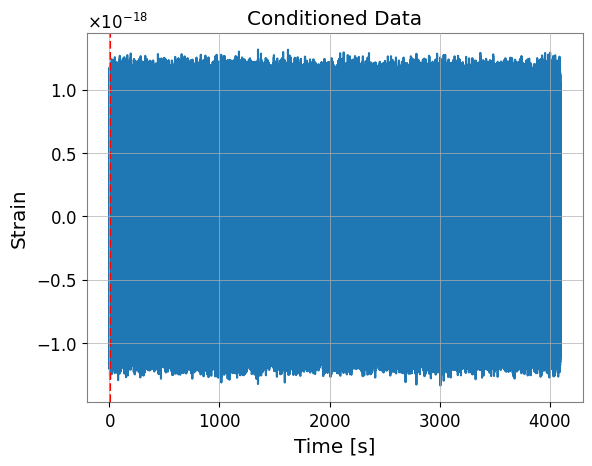

In [40]:
plt.plot(conditioned.sample_times, conditioned)
plt.axvline(10, color='r', linestyle='--')
plt.title("Conditioned Data")
plt.xlabel("Time [s]")
plt.ylabel("Strain")

In [41]:
print(snr_sig_peaks)
print(time_list)

[array([ 4.42751438,  4.5663314 ,  4.35703612,  4.57440299,
        4.86276719,  4.86357878,  4.97788064,  4.3541398 ,
        4.18850989,  5.35973702,  4.44450961,  4.81038302,
        4.41649513,  4.37797681,  4.61028197,  4.57864109,
        4.65920471,  4.63773633,  4.45003858,  4.58774886,
        4.55550912,  4.61594393,  4.32216376,  4.96815725,
        4.81020411,  4.36656744,  4.39960958,  4.85391526,
        4.66198035,  5.0946364 ,  4.77602141,  5.03080583,
        5.20479027,  5.2588935 ,  4.81805963,  5.15878007,
        3.76990836,  4.06899291,  3.79867908,  3.8877923 ,
        4.85438832,  4.81008634,  4.86181847,  4.44902651,
        4.56162461,  5.01659854,  4.92956104,  4.01934799,
        4.18084729,  5.3466898 ,  4.5322123 ,  4.48960788,
        5.06859372,  5.24036176,  5.14237532,  5.10872438,
        5.40273254,  5.0320828 ,  5.22657184,  5.17022362,
        5.03100396,  4.98808765,  4.63070521,  5.20713824,
        4.91177233,  4.75130038,  5.17010443,  5.289490

In [42]:
peak_arr = np.concatenate(snr_sig_peaks)
print(peak_arr > 8)

[False False False ... False False False]


In [43]:
significant_peaks = []
significant_times = []

for i, peaks in enumerate(snr_sig_peaks):
    significant_indices = np.where(peaks > 8)[0]
    for index in significant_indices:
        significant_peaks.append(peaks[index])
        significant_times.append(time_list[i])

print("Significant SNR peaks:", np.array(significant_peaks))
print("Corresponding times:", np.array(significant_times))

Significant SNR peaks: [25.86665835  8.59693571  8.76262689 ...  8.85884395  8.89873367
 12.74986985]
Corresponding times: [2483.9675293  2483.9675293  1638.20849609 ... 2892.69750977
 2892.69750977 2892.69750977]


In [44]:
from collections import defaultdict

# Group events by time
event_groups = defaultdict(list)
for time, snr in zip(significant_times, significant_peaks):
    # Round the time to group nearby events
    event_groups[round(time, 1)].append((time, snr))

# Find the best-fit mass for each event
for rounded_time, events in event_groups.items():
    # Find the event with the highest SNR in the group
    #Max returns the tuple with the corresponding maximum snr
    best_time, best_snr = max(events, key=lambda item: item[1])

    # Find the index of the time in the original time_list
    # This index will correspond to the mass in the mass array
    time_index = time_list.index(best_time)
    best_mass = mass[time_index]

    print(f"Event at ~{rounded_time}s:")
    print(f"  Best SNR: {best_snr:.2f}")
    print(f"  Best-fit mass: {best_mass} solar masses")

Event at ~2484.0s:
  Best SNR: 25.87
  Best-fit mass: 10 solar masses
Event at ~1638.2s:
  Best SNR: 32.40
  Best-fit mass: 17 solar masses
Event at ~2892.7s:
  Best SNR: 39.30
  Best-fit mass: 22 solar masses


## Computing the posterior

In [9]:
import bilby
from bilby.gw import WaveformGenerator
from gwpy.timeseries import TimeSeries

events = [
    {'time': 2484.0, 'mass': 10, 'duration': 8, 'psd_duration': 16},
    {'time': 1638.2, 'mass': 17, 'duration': 8, 'psd_duration': 16},
    {'time': 2892.7, 'mass': 22, 'duration': 8, 'psd_duration': 16}
]

for event in events:
    start_time = event['time'] - event['duration'] + 1
    end_time = event['time'] + 1
    #one second after the ringdown and 4 seconds before the peak

    ifo = bilby.gw.detector.get_empty_interferometer('L1')
    #load strain on ifo object
    ifo.set_strain_data_from_frame_file(
        'challenge3.gwf',
        sampling_frequency=2048,
        duration=event['duration'],
        start_time=start_time,
        channel='L1:CHALLENGE3'
    )


    psd_start_time = start_time - event['psd_duration']
    psd_end_time = start_time

    # Use gwpy to calculate the PSD
    psd_data = TimeSeries.read(
        'challenge3.gwf',
        start=psd_start_time,
        end=psd_end_time,
        channel='L1:CHALLENGE3'
    )
    psd = psd_data.psd(fftlength=4)

    # Set the PSD for the interferometer
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )


    #generate waveform
    waveform_generator = WaveformGenerator(
        duration=event['duration'],
        sampling_frequency=2048,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(
            waveform_approximant='SEOBNRv4_opt',
            reference_frequency=50.0,
            minimum_frequency=20.0
        )
    )

    priors = bilby.gw.prior.BBHPriorDict()
    # Set a prior on chirp_mass and fix mass_ratio
    priors['chirp_mass'] = bilby.core.prior.Uniform(
        name='chirp_mass',
        minimum=event['mass'] * 0.8,
        maximum=event['mass'] * 1.2
    )
    priors['mass_ratio'] = 1  # Fixing mass ratio to 1
    priors['a_1'] = 0
    priors['a_2'] = 0
    priors['tilt_1'] = 0
    priors['tilt_2'] = 0
    priors['phi_12'] = 0
    priors['phi_jl'] = 0
    priors['psi'] = 0
    priors['ra'] = 0
    priors['dec'] = 0
    priors['geocent_time'] = bilby.core.prior.Uniform(
        event['time'] - 0.1, event['time'] + 0.1, name="geocent_time"
    )


    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
        interferometers=[ifo],
        waveform_generator=waveform_generator,
        priors=priors,
        time_marginalization=False, # Time is a parameter, so no marginalization
        phase_marginalization=True,
        distance_marginalization=True,
    )

    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler='dynesty',
        npoints=100,
        outdir=f"event_{event['time']}",
        label=f"mass_{event['mass']}",
        clean=True
    )

    result.plot_corner()

09:12 bilby INFO    : Reading data from frame file challenge3.gwf
09:12 bilby INFO    : Successfully loaded L1:CHALLENGE3.
09:12 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
09:12 bilby INFO    : No prior given, using default BBH priors in /usr/local/lib/python3.11/dist-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
09:12 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
09:12 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

09:14 bilby INFO    : Running for label 'mass_10', output will be saved to 'event_2484.0'
09:14 bilby INFO    : Using lal version 7.6.1
09:14 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.25;Id: fafc22fe7c166517798534eeca175f27a66e0138;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
09:14 bilby INFO    : Using lalsimulation version 6.1.0
09:14 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.25;Id: fafc22fe7c166517798534eeca175f27a66e0138;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
09:14 bilby INFO    : Analysis priors:
09:14 bilby INFO    : chirp_mass=Uniform(minimum=8.0, maximum=12.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
09:14 bilby INFO    : theta_jn=Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None)
09:14 bilby INFO    : geocent_time=Uniform(minimum=2483.9, maximu

1it [00:00, ?it/s]

09:25 bilby INFO    : Written checkpoint file event_2484.0/mass_10_resume.pickle
/usr/local/lib/python3.11/dist-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/usr/local/lib/python3.11/dist-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
09:43 bilby INFO    : Written checkpoint file event_2484.0/mass_10_resume.pickle
09:54 bilby INFO    : Written checkpoint file event_2484.0/mass_10_resume.pickle
/usr/local/lib/python3.11/dist-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/usr/local/lib/python3.11/dist-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-

11:32 bilby INFO    : Reading data from frame file challenge3.gwf
11:32 bilby INFO    : Successfully loaded L1:CHALLENGE3.
11:33 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:33 bilby INFO    : No prior given, using default BBH priors in /usr/local/lib/python3.11/dist-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
11:33 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
11:33 bilby INFO    : Running for label 'mass_17', output will be saved to 'event_1638.2'
11:33 bilby INFO    : Using lal version 7.6.1
11:33 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.25;Id: fafc22fe7c166517798534eeca175f27a66e0138;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
11:33 bilby INFO    : Usin

1it [00:00, ?it/s]

11:44 bilby INFO    : Written checkpoint file event_1638.2/mass_17_resume.pickle
11:44 bilby WARNING : The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
11:44 bilby WARNING : Failed to create dynesty state plot at checkpoint
11:44 bilby WARNING : The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
11:44 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/usr/local/lib/p

Exception while calling loglikelihood function:
  params: [1.48130292e+01 8.08651351e-01 1.63817347e+03]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bilby/core/sampler/dynesty.py", line 54, in _log_likelihood_wrapper
    return _sampling_convenience_dump.likelihood.log_likelihood_ratio()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bilby/gw/likelihood/base.py", line 408, in log_likelihood_ratio
    self.waveform_generator.frequency_domain_strain(self.parameters)
  File "/usr/local/lib/python3.11/dist-packages/bilby/gw/waveform_generator.py", line 131, in frequency_domain_strain
    return self._calculate_strain(model=self.frequency_domain_source_model,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/

SystemExit: 130

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Took too long to sample just the first event

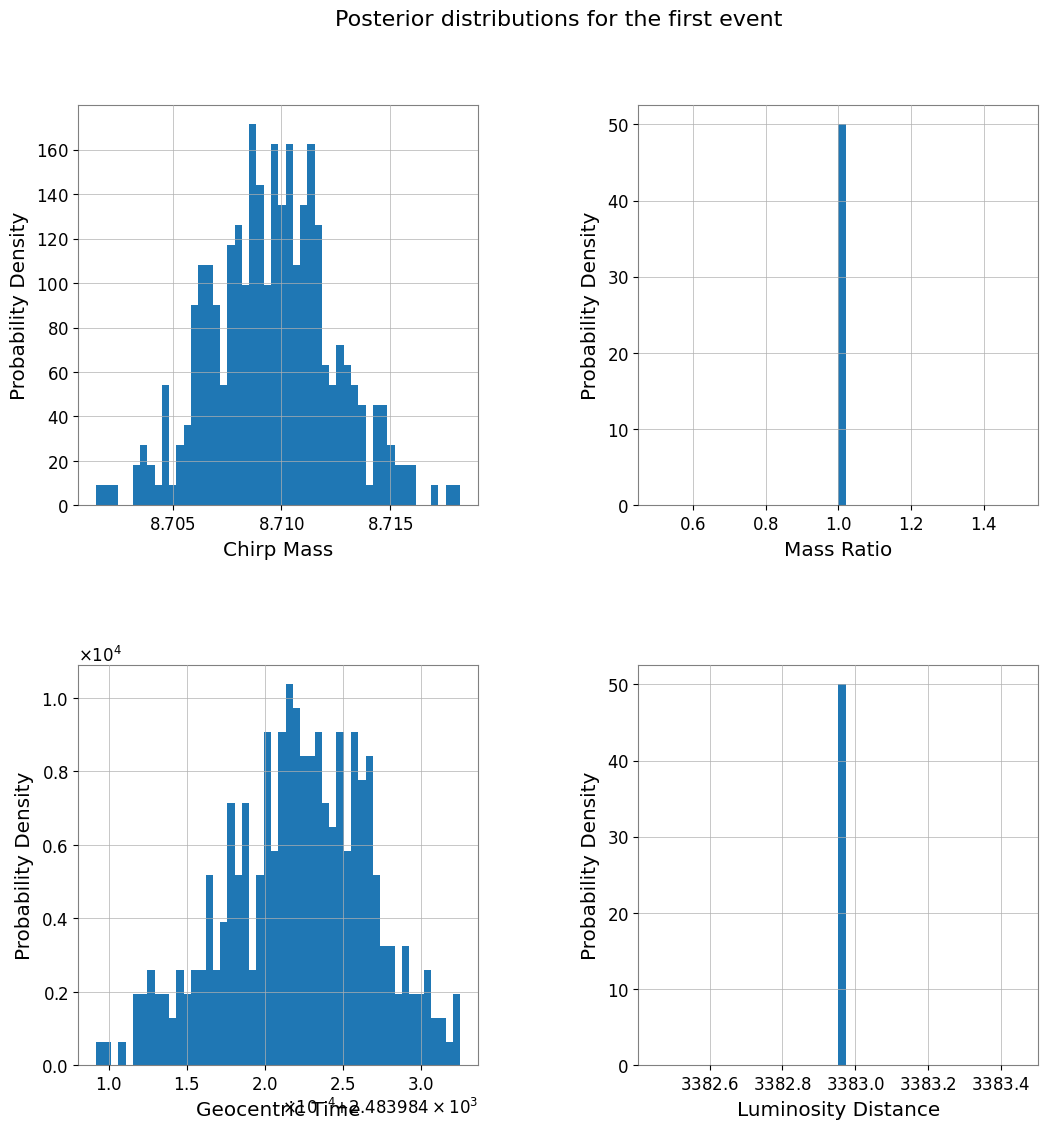

In [14]:
import matplotlib.pyplot as plt

if 'result' in locals() and result.posterior is not None:
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Posterior distributions for the first event', fontsize=16)

    # Plot the posterior distribution for chirp_mass
    axes[0, 0].hist(result.posterior['chirp_mass'], bins=50, density=True)
    axes[0, 0].set_xlabel('Chirp Mass')
    axes[0, 0].set_ylabel('Probability Density')

    # Plot the posterior distribution for mass_ratio
    axes[0, 1].hist(result.posterior['mass_ratio'], bins=50, density=True)
    axes[0, 1].set_xlabel('Mass Ratio')
    axes[0, 1].set_ylabel('Probability Density')

    # Plot the posterior distribution for geocent_time
    axes[1, 0].hist(result.posterior['geocent_time'], bins=50, density=True)
    axes[1, 0].set_xlabel('Geocentric Time')
    axes[1, 0].set_ylabel('Probability Density')

    # Plot the posterior distribution for luminosity_distance
    axes[1, 1].hist(result.posterior['luminosity_distance'], bins=50, density=True)
    axes[1, 1].set_xlabel('Luminosity Distance')
    axes[1, 1].set_ylabel('Probability Density')

    # Adjust the spacing between the subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

    plt.show()

In [ ]:
import nbformat
from google.colab import drive
import os

# Monta Google Drive se il notebook è salvato lì
drive.mount('/content/drive')

# Sostituisci col nome reale del tuo notebook, es: "data_challenge.ipynb"
input_file = "/content/drive/MyDrive/Colab Notebooks/Data challenge.ipynb"  # Esempio di percorso in Google Drive
output_file = "data_challenge_pulito.ipynb"

# Controlla se il file esiste
if not os.path.exists(input_file):
    print(f"Errore: il file '{input_file}' non è stato trovato. Controlla il percorso e il nome del file.")
else:
    # Leggi il notebook
    with open(input_file, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

    # Rimuovi 'widgets' se presente
    if 'widgets' in nb.get('metadata', {}):
        print("Rimuovo metadata.widgets...")
        del nb['metadata']['widgets']

    # Salva la versione ripulita
    with open(output_file, "w", encoding="utf-8") as f:
        nbformat.write(nb, f)

    print(f"Notebook pulito salvato come: {output_file}")